In [67]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from itertools import product

In [57]:
df = pd.read_csv('..\data\imputed_dataset.csv')
df.head()

,rating,ranking,year,position,height,weight,latitude,longitude,state_province,stars,...,school,season,wins_rolling_2year,games_played_rolling_2year,post_season_wins_rolling_2year,point_diff_rolling_2year,win_pct_rolling_2year,distance_miles,side_of_ball,position_group
0,0.9644,71.0,2012,DT,76.0,290.0,35.334011,-81.865103,NC,4,...,Clemson,2012.0,16.0,27.0,0.0,128.0,0.846154,71.511790,defense,d_line
1,0.9632,79.0,2012,WR,71.0,175.0,35.227200,-80.843083,NC,4,...,Clemson,2012.0,16.0,27.0,0.0,128.0,0.846154,119.438575,offense,pass_catcher
2,0.9567,92.0,2012,S,73.0,195.0,30.438083,-84.280933,FL,4,...,Clemson,2012.0,16.0,27.0,0.0,128.0,0.846154,304.721993,defense,d_backfield
3,0.9264,187.0,2012,DUAL,75.0,205.0,42.886717,-78.878392,NY,4,...,Clemson,2012.0,16.0,27.0,0.0,128.0,0.846154,605.799029,offense,qb
4,0.9133,231.0,2012,ATH,73.0,180.0,35.842865,-90.703452,AR,4,...,Clemson,2012.0,16.0,27.0,0.0,128.0,0.846154,450.556207,athlete,athlete


In [58]:
print(f"Percent of all players drafted: {round(len(df[df['is_drafted'] == 1.0]) / len(df) * 100, 2)}%")

Percent of all players drafted: 8.51%


In [59]:
len(df[df['is_drafted'] == 1.0])

2039

In [60]:
# Define numerical and categorical values
numerical_features = ['rating', 'ranking', 'height', 'weight', 'distance_miles', 'stars', 'wins_rolling_2year', 'games_played_rolling_2year', 'post_season_wins_rolling_2year', 'point_diff_rolling_2year', 'win_pct_rolling_2year']
categorical_features = ['conference', 'side_of_ball', 'position_group', 'season']
target = ['is_drafted']


In [61]:
# Features and target
X = df[numerical_features+categorical_features]
y = df[target]

In [62]:
def create_pipeline(eps=0.5, min_samples=5, metric='euclidean', alg='auto', leaf_size=30, p=None):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )

    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=2)),
        ('classifier', DBSCAN(eps=eps, min_samples=min_samples, metric=metric, algorithm=alg, leaf_size=leaf_size, p=p))
    ])
    return pipe, preprocessor

pipe, preprocessor = create_pipeline()

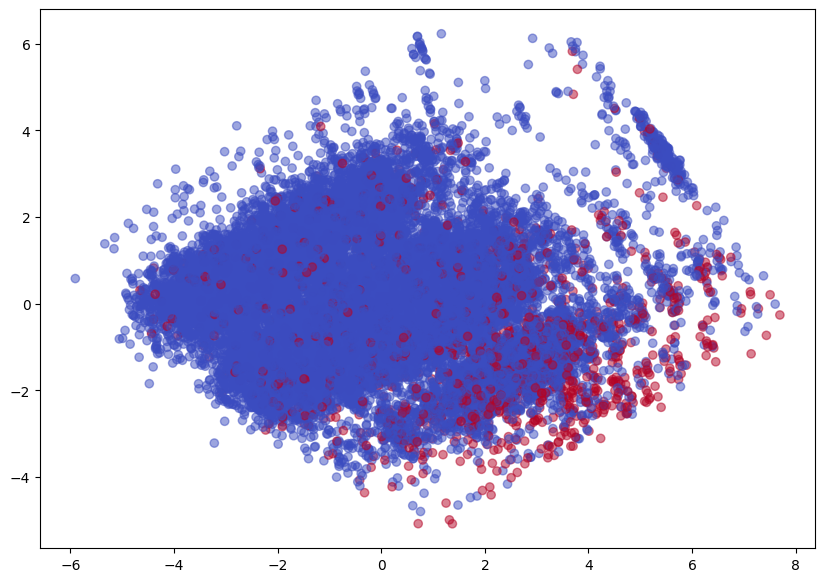

In [109]:
pipe, preprocessor = create_pipeline(eps=.25, min_samples=20)
clusters = pipe.fit_predict(X)
pca_data = pipe.named_steps['pca'].fit_transform(preprocessor.fit_transform(X))
df['cluster'] = clusters
plt.figure(figsize=(10, 7))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=df['is_drafted'], cmap='coolwarm', alpha=0.5)
plt.show()

In [110]:
cluster_summary = df.groupby('cluster')['is_drafted'].agg(['sum', 'count'])
cluster_summary['proportion_drafted'] = cluster_summary['sum'] / cluster_summary['count']
cluster_summary = cluster_summary.sort_values('proportion_drafted', ascending=False)
cluster_summary

,sum,count,proportion_drafted
cluster,,,
5,13.0,20,0.650000
1,9.0,29,0.310345
2,24.0,82,0.292683
-1,191.0,760,0.251316
3,5.0,27,0.185185
6,3.0,20,0.150000
0,1781.0,22814,0.078066
4,12.0,180,0.066667
7,1.0,15,0.066667


In [ ]:
pipe, preprocessor = create_pipeline(eps=10)
clusters = pipe.fit_predict(X)
pca_data = pipe.named_steps['pca'].fit_transform(preprocessor.fit_transform(X))
df['cluster'] = clusters

plt.scatter()


In [111]:
# Define parameters
eps = [0.1, 0.25, 0.5, 1]
min_samples = [3, 5, 10]
metrics = ['euclidean', 'cityblock']
algs = ['auto', 'ball_tree', 'kd_tree']
p = [1, 2, 4]

all_combos = list(product(eps, min_samples, metrics, algs, p))
num_combos = len(all_combos)

num_cols = 5
num_rows = (num_combos + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 5 * num_rows))
axes = axes.flatten()

for idx, (ep, min_sample, metric, alg, p_val) in enumerate(all_combos):
    ax = axes[idx]  # Get the correct subplot
    pipe, preprocessor = create_pipeline(ep, min_sample, metric, alg, p_val)
    clusters = pipe.fit_predict(X)
    pca_data = pipe.named_steps['pca'].fit_transform(preprocessor.fit_transform(X))
    df['cluster'] = clusters

    scatter = ax.scatter(pca_data[:, 0], pca_data[:, 1], c=df['is_drafted'], cmap='coolwarm', alpha=0.5)
    fig.colorbar(scatter, label='is_drafted', ax=ax)
    
    #ax.set_title(f'ep: {ep}, min_sample: {min_sample}, metric: {metric}, alg: {alg}, p_val: {p_val}')
    #ax.set_xlabel('PCA Component 1')
    #ax.set_ylabel('PCA Component 2')

# Hide any unused subplots if they exist
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()
